# Tutorial Part 7: Uncertainty in Deep Learning

A common criticism of deep learning models is that they tend to act as black boxes.  A model produces outputs, but doesn't given enough context to interpret them properly.  How reliable are the model's predictions?  Are some predictions more reliable than others?  If a model predicts a value of 5.372 for some quantity, should you assume the true value is between 5.371 and 5.373?  Or that it's between 2 and 8?  In some fields this situation might be good enough, but not in science.  For every value predicted by a model, we also want an estimate of the uncertainty in that value so we can know what conclusions to draw based on it.

DeepChem makes it very easy to estimate the uncertainty of predicted outputs (at least for the models that support it—not all of them do).  Let's start by seeing an example of how to generate uncertainty estimates.  We load a dataset, create a model, train it on the training set, predict the output on the test set, and then derive some uncertainty estimates.

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/07_Uncertainty_In_Deep_Learning.ipynb)

## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands. This will take about 5 minutes to run to completion and install your environment.

In [1]:
!wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
!chmod +x Anaconda3-2019.10-Linux-x86_64.sh
!bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-03-07 01:16:48--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M  8.46MB/s    in 90s     

2020-03-07 01:18:18 (5.65 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaconda-navigator==1.9.7=py37_0


We'll use the SAMPL dataset from the MoleculeNet suite to run our experiments in this tutorial. Let's load up our dataset for our experiments, and then make some uncertainty predictions.

In [2]:
import deepchem as dc
import numpy as np
import matplotlib.pyplot as plot

tasks, datasets, transformers = dc.molnet.load_sampl(reload=False)
train_dataset, valid_dataset, test_dataset = datasets

model = dc.models.MultitaskRegressor(len(tasks), 1024, uncertainty=True)
model.fit(train_dataset, nb_epoch=200)
y_pred, y_std = model.predict_uncertainty(test_dataset)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /tmp/SAMPL.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 1.802 s
TIMING: dataset construction took 1.898 s
Loading dataset from disk.
TIMING: dataset construction took 0.038 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
TIMING: dataset construction took 0.035 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s

All of this looks exactly like any other example, with just two differences.  First, we add the option `uncertainty=True` when creating the model.  This instructs it to add features to the model that are needed for estimating uncertainty.  Second, we call `predict_uncertainty()` instead of `predict()` to produce the output.  `y_pred` is the predicted outputs.  `y_std` is another array of the same shape, where each element is an estimate of the uncertainty (standard deviation) of the corresponding element in `y_pred`.  And that's all there is to it!  Simple, right?

Of course, it isn't really that simple at all.  DeepChem is doing a lot of work to come up with those uncertainties.  So now let's pull back the curtain and see what is really happening.  (For the full mathematical details of calculating uncertainty, see https://arxiv.org/abs/1703.04977)

To begin with, what does "uncertainty" mean?  Intuitively, it is a measure of how much we can trust the predictions.  More formally, we expect that the true value of whatever we are trying to predict should usually be within a few standard deviations of the predicted value.  But uncertainty comes from many sources, ranging from noisy training data to bad modelling choices, and different sources behave in different ways.  It turns out there are two fundamental types of uncertainty we need to take into account.

### Aleatoric Uncertainty

Consider the following graph.  It shows the best fit linear regression to a set of ten data points.

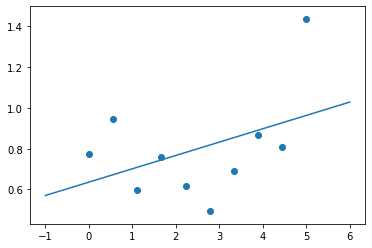

In [3]:
# Generate some fake data and plot a regression line.
x = np.linspace(0, 5, 10)
y = 0.15*x + np.random.random(10)
plot.scatter(x, y)
fit = np.polyfit(x, y, 1)
line_x = np.linspace(-1, 6, 2)
plot.plot(line_x, np.poly1d(fit)(line_x))
plot.show()

The line clearly does not do a great job of fitting the data.  There are many possible reasons for this.  Perhaps the measuring device used to capture the data was not very accurate.  Perhaps `y` depends on some other factor in addition to `x`, and if we knew the value of that factor for each data point we could predict `y` more accurately.  Maybe the relationship between `x` and `y` simply isn't linear, and we need a more complicated model to capture it.  Regardless of the cause, the model clearly does a poor job of predicting the training data, and we need to keep that in mind.  We cannot expect it to be any more accurate on test data than on training data.  This is known as *aleatoric uncertainty*.

How can we estimate the size of this uncertainty?  By training a model to do it, of course!  At the same time it is learning to predict the outputs, it is also learning to predict how accurately each output matches the training data.  For every output of the model, we add a second output that produces the corresponding uncertainty.  Then we modify the loss function to make it learn both outputs at the same time.

### Epistemic Uncertainty

Now consider these three curves.  They are fit to the same data points as before, but this time we are using 10th degree polynomials.

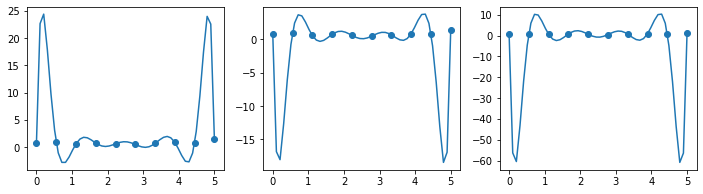

In [4]:
plot.figure(figsize=(12, 3))
line_x = np.linspace(0, 5, 50)
for i in range(3):
    plot.subplot(1, 3, i+1)
    plot.scatter(x, y)
    fit = np.polyfit(np.concatenate([x, [3]]), np.concatenate([y, [i]]), 10)
    plot.plot(line_x, np.poly1d(fit)(line_x))
plot.show()

Each of them perfectly interpolates the data points, yet they clearly are different models.  (In fact, there are infinitely many 10th degree polynomials that exactly interpolate any ten data points.)  They make identical predictions for the data we fit them to, but for any other value of `x` they produce different predictions.  This is called *epistemic uncertainty*.  It means the data does not fully constrain the model.  Given the training data, there are many different models we could have found, and those models make different predictions.

The ideal way to measure epistemic uncertainty is to train many different models, each time using a different random seed and possibly varying hyperparameters.  Then use all of them for each input and see how much the predictions vary.  This is very expensive to do, since it involves repeating the whole training process many times.  Fortunately, we can approximate the same effect in a less expensive way: by using dropout.

Recall that when you train a model with dropout, you are effectively training a huge ensemble of different models all at once.  Each training sample is evaluated with a different dropout mask, corresponding to a different random subset of the connections in the full model.  Usually we only perform dropout during training and use a single averaged mask for prediction.  But instead, let's use dropout for prediction too.  We can compute the output for lots of different dropout masks, then see how much the predictions vary.  This turns out to give a reasonable estimate of the epistemic uncertainty in the outputs.

### Uncertain Uncertainty?

Now we can combine the two types of uncertainty to compute an overall estimate of the error in each output:

$$\sigma_\text{total} = \sqrt{\sigma_\text{aleatoric}^2 + \sigma_\text{epistemic}^2}$$

This is the value DeepChem reports.  But how much can you trust it?  Remember how I started this tutorial: deep learning models should not be used as black boxes.  We want to know how reliable the outputs are.  Adding uncertainty estimates does not completely eliminate the problem; it just adds a layer of indirection.  Now we have estimates of how reliable the outputs are, but no guarantees that those estimates are themselves reliable.

Let's go back to the example we started with.  We trained a model on the SAMPL training set, then generated predictions and uncertainties for the test set.  Since we know the correct outputs for all the test samples, we can evaluate how well we did.  Here is a plot of the absolute error in the predicted output versus the predicted uncertainty.

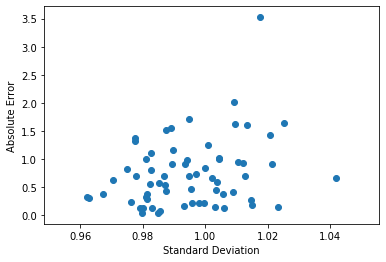

In [5]:
abs_error = np.abs(y_pred.flatten()-test_dataset.y.flatten())
plot.scatter(y_std.flatten(), abs_error)
plot.xlabel('Standard Deviation')
plot.ylabel('Absolute Error')
plot.show()

The first thing we notice is that the axes have similar ranges.  The model clearly has learned the overall magnitude of errors in the predictions.  There also is clearly a correlation between the axes.  Values with larger uncertainties tend on average to have larger errors.

Now let's see how well the values satisfy the expected distribution.  If the standard deviations are correct, and if the errors are normally distributed (which is certainly not guaranteed to be true!), we expect 95% of the values to be within two standard deviations, and 99% to be within three standard deviations.  Here is a histogram of errors as measured in standard deviations.

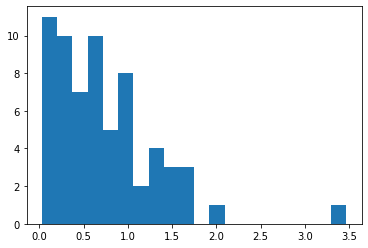

In [6]:
plot.hist(abs_error/y_std.flatten(), 20)
plot.show()

Most of the values are in the expected range, but there are a handful of outliers at much larger values.  Perhaps this indicates the errors are not normally distributed, but it may also mean a few of the uncertainties are too low.  This is an important reminder: the uncertainties are just estimates, not rigorous measurements.  Most of them are pretty good, but you should not put too much confidence in any single value.

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on GitHub
Starring DeepChem on GitHub helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!